In [1]:
# https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb

In [2]:
from pydoc import classname

from data_loader.data_loader import load_and_split_data

import torch as t
from rich.pretty import pprint
from datasets import load_dataset
import pandas as pd
import plotly.express as px
import time
from dataclasses import dataclass
from torchmetrics.classification import Accuracy, F1Score
from torchmetrics import MeanAbsoluteError
from tqdm import tqdm

from notebooks.dataset_dataloader import create_data_loader
from visualizations.visualizations import plot_tokens_sequence_lengths, plot_training_history

In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
@dataclass
class Config:
    batch_size: int
    model: str
    seed: int
    lr: float
    epochs: int
    lora_r: int
    lora_alpha: float
    device: str
    num_classes: int

# Determine the best available device
if t.cuda.is_available():
    device = "cuda"
elif t.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

config = Config(
    batch_size = 32,
    model = "bert-large-cased", # "microsoft/deberta-v3-large", # "google/flan-t5-small", # TODO: small has 80 million tokens, but we can do ablation study going up to 11B for xxl model: https://huggingface.co/google/flan-t5-xxl
    seed = 42,
    lr = 3e-5,
    epochs = 4,
    # For LoRA
    lora_r = 16,
    lora_alpha = 32,  # a common choice is alpha = 2 * rank
    device=device,
    num_classes=3
)

def set_seed(seed: int) -> None:
    import os
    import random

    import numpy as np

    np.random.seed(seed)
    random.seed(seed)
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    t.mps.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(config.seed)

Random seed set as 42


In [5]:
train_df, val_df, test_df = load_and_split_data()

In [6]:
tokenizer = BertTokenizer.from_pretrained(config.model)

### Choosing Sequence Length

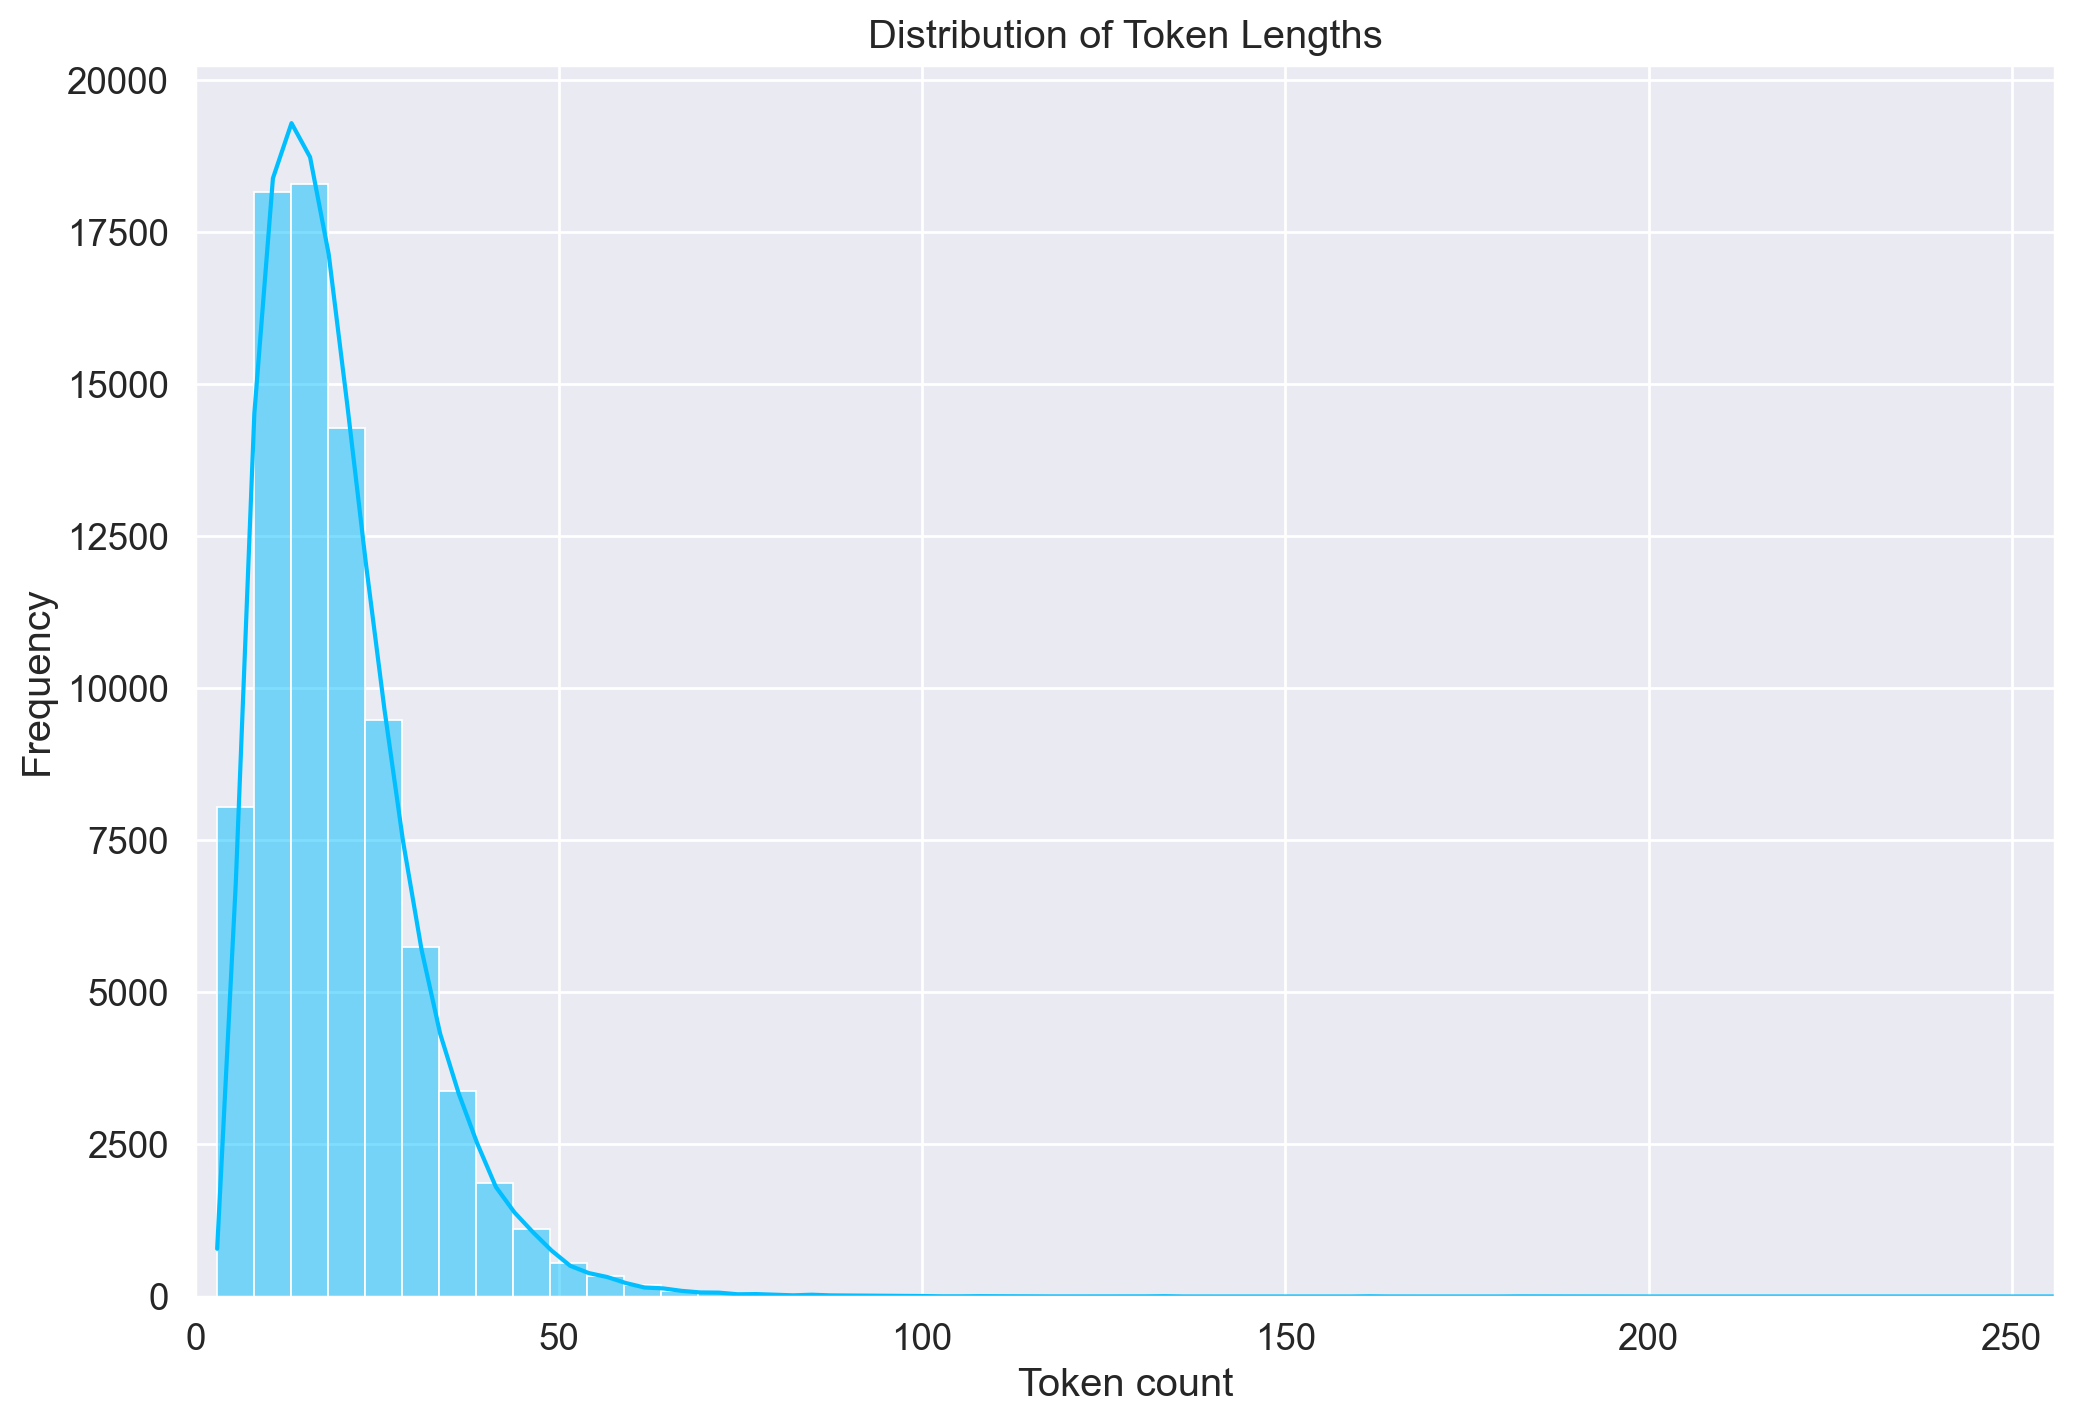

In [43]:
plot_tokens_sequence_lengths(train_df, tokenizer)

Most of the sentences are less than 50 tokens long.
We can set the maximum length to 60 tokens to be on the safe side.
This will help in reducing the computational cost and memory usage during training.

In [9]:
MAX_LEN = 60

In [10]:
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, config.batch_size)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, config.batch_size)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, config.batch_size)

In [11]:
bert_model = BertModel.from_pretrained(config.model)

For personal curiosity, let's see how the model looks like.

In [12]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  # pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [14]:
last_hidden_state, pooled_output = output.last_hidden_state, output.pooler_output

In [15]:
last_hidden_state.shape

torch.Size([1, 17, 1024])

In [16]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(config.model)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(output.pooler_output)
    return self.out(output)

In [17]:
model = SentimentClassifier(config.num_classes)
model = model.to(device)

Personal curiosity

In [18]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [19]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 60])
torch.Size([32, 60])
torch.Size([32])


In [20]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 60])
torch.Size([32, 60])


In [21]:
F.softmax(model(input_ids, attention_mask), dim=1).detach().cpu().numpy()

array([[0.44274855, 0.3085799 , 0.24867153],
       [0.40621352, 0.32734898, 0.26643753],
       [0.54323703, 0.321571  , 0.13519198],
       [0.3747055 , 0.33566102, 0.2896335 ],
       [0.28585565, 0.47283772, 0.24130674],
       [0.2255711 , 0.6604406 , 0.11398832],
       [0.28636014, 0.3149428 , 0.39869705],
       [0.39011213, 0.31181547, 0.29807246],
       [0.44342586, 0.3845257 , 0.17204838],
       [0.40212443, 0.45997992, 0.13789573],
       [0.27714875, 0.5400914 , 0.1827598 ],
       [0.37150252, 0.43763232, 0.19086511],
       [0.31721902, 0.32374316, 0.35903788],
       [0.32962605, 0.5217722 , 0.14860179],
       [0.36572188, 0.45586812, 0.17840995],
       [0.31523484, 0.37661362, 0.30815157],
       [0.3191812 , 0.46637818, 0.21444069],
       [0.4631411 , 0.35824624, 0.17861265],
       [0.46417367, 0.25510466, 0.28072163],
       [0.32376927, 0.46052295, 0.21570772],
       [0.53515923, 0.26515275, 0.19968794],
       [0.2916711 , 0.33515176, 0.37317714],
       [0.

In [22]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * config.epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.float() / n_examples, np.mean(losses)


In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.float() / n_examples, np.mean(losses)

In [25]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(config.epochs):

  print(f'Epoch {epoch + 1}/{config.epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_df)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val_df)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_distilbert_32_batch_4epoch.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.6638429331816835 accuracy 0.7219657897949219
Val   loss 0.5555320313666016 accuracy 0.7745347619056702

Epoch 2/4
----------
Train loss 0.40554290260175513 accuracy 0.8458929657936096
Val   loss 0.6287459050770849 accuracy 0.7789422273635864

Epoch 3/4
----------
Train loss 0.2404049639015532 accuracy 0.9181165099143982
Val   loss 0.7575585968414089 accuracy 0.772282063961029

Epoch 4/4
----------
Train loss 0.15810942989620835 accuracy 0.9519938230514526
Val   loss 0.9323725270107388 accuracy 0.7786483764648438

CPU times: user 37min 16s, sys: 12min 8s, total: 49min 24s
Wall time: 1h 39min 16s


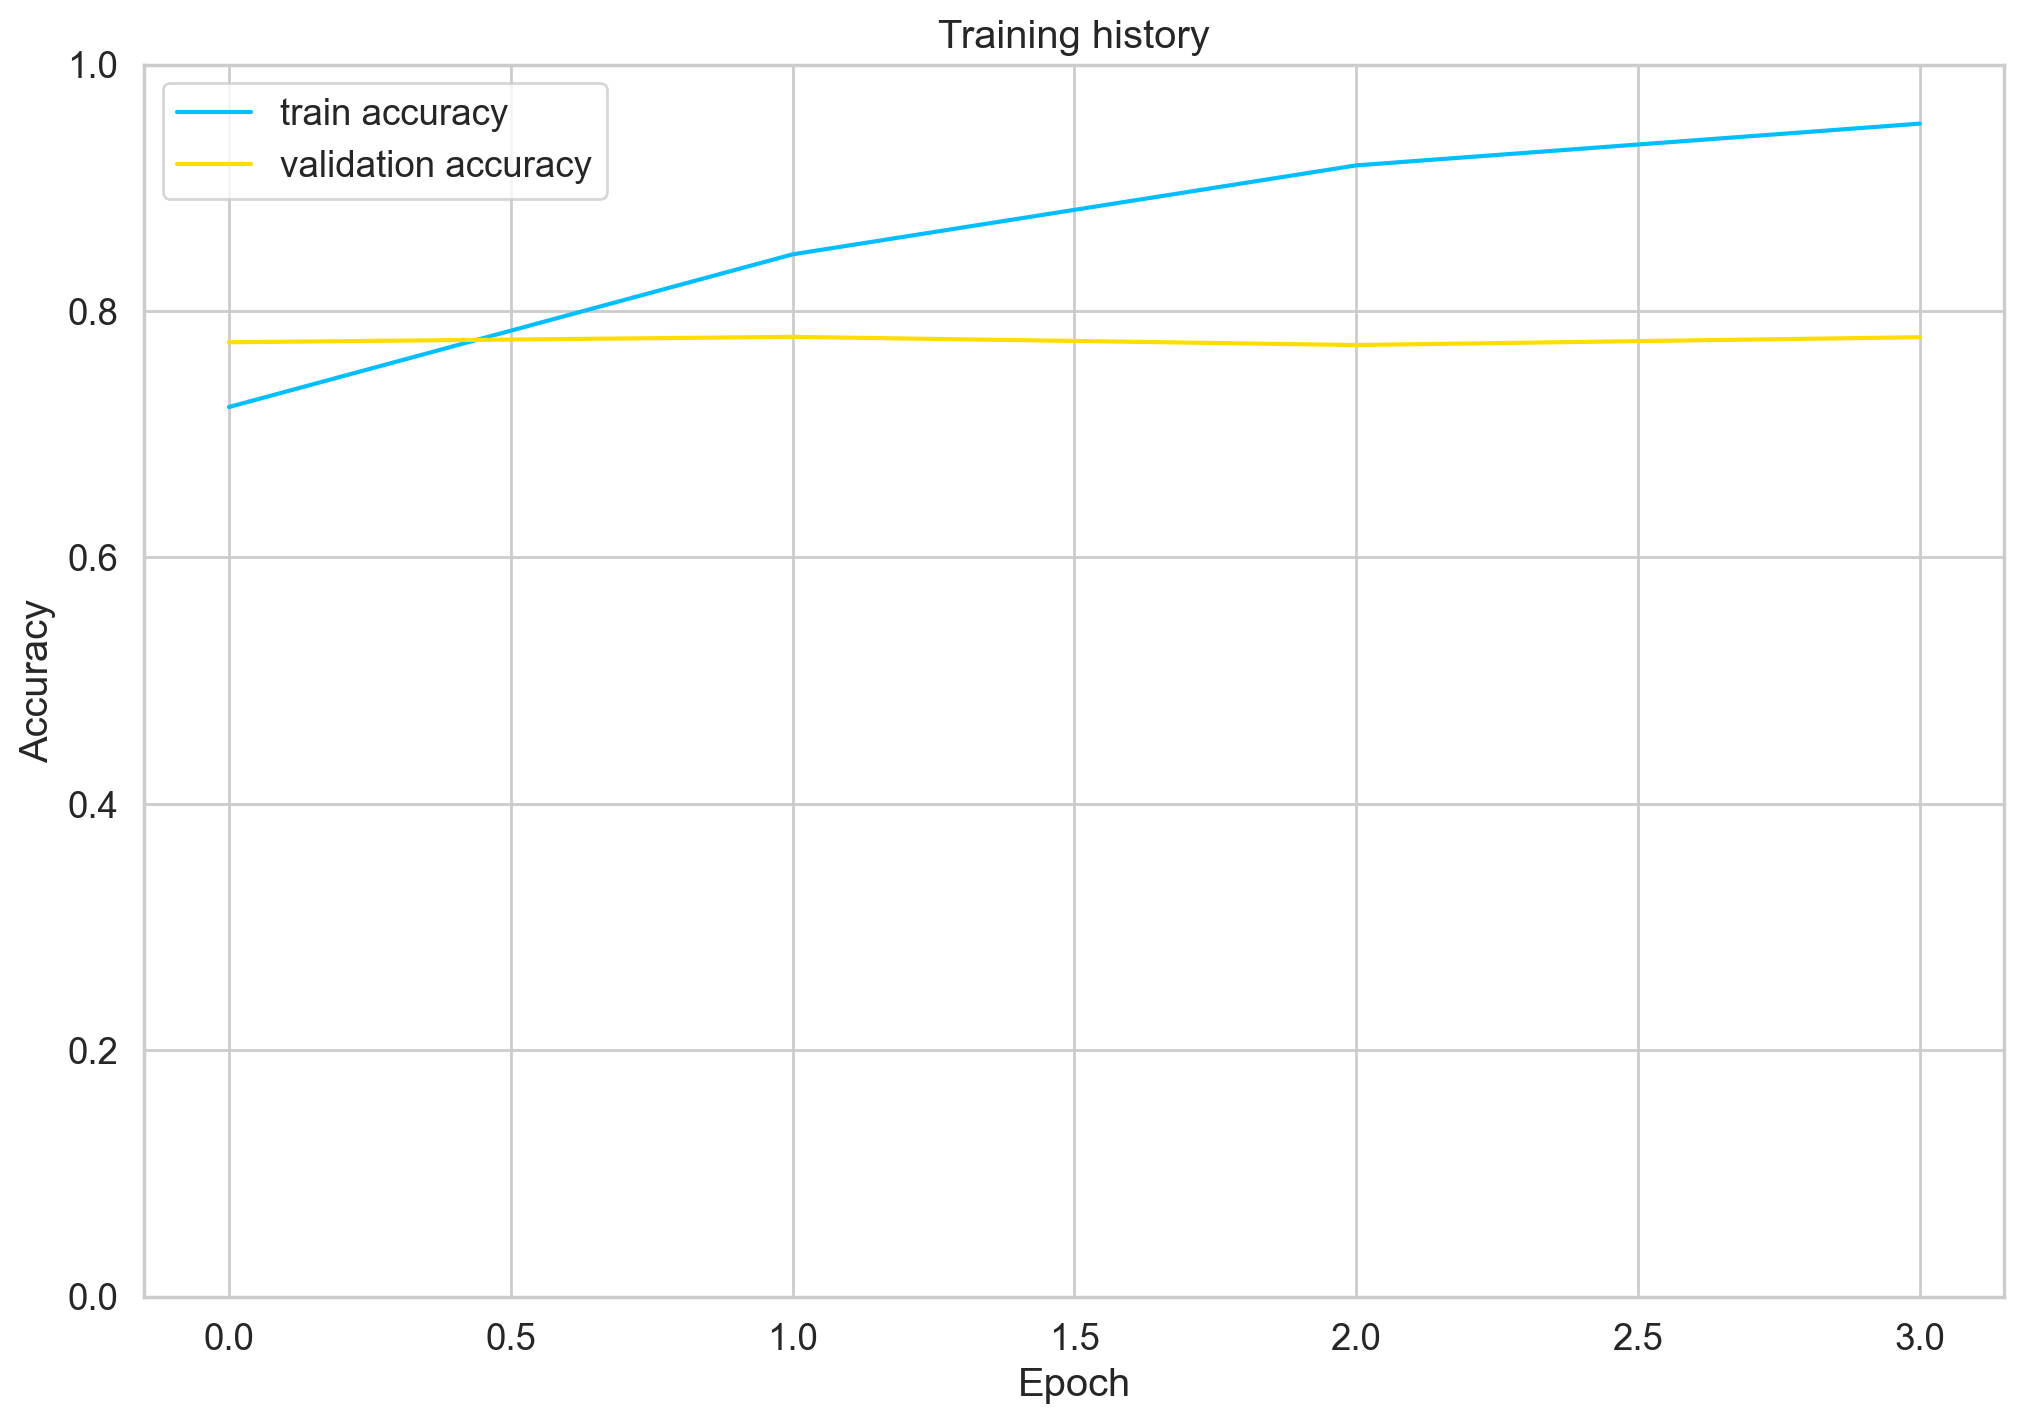

In [26]:
plot_training_history(history)

### Evaluation

In [27]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)

test_acc.item()

0.7827619910240173

In [28]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [29]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [30]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.74      0.70      0.72      2191
     neutral       0.80      0.83      0.82      4915
    positive       0.78      0.76      0.77      3104

    accuracy                           0.78     10210
   macro avg       0.77      0.77      0.77     10210
weighted avg       0.78      0.78      0.78     10210



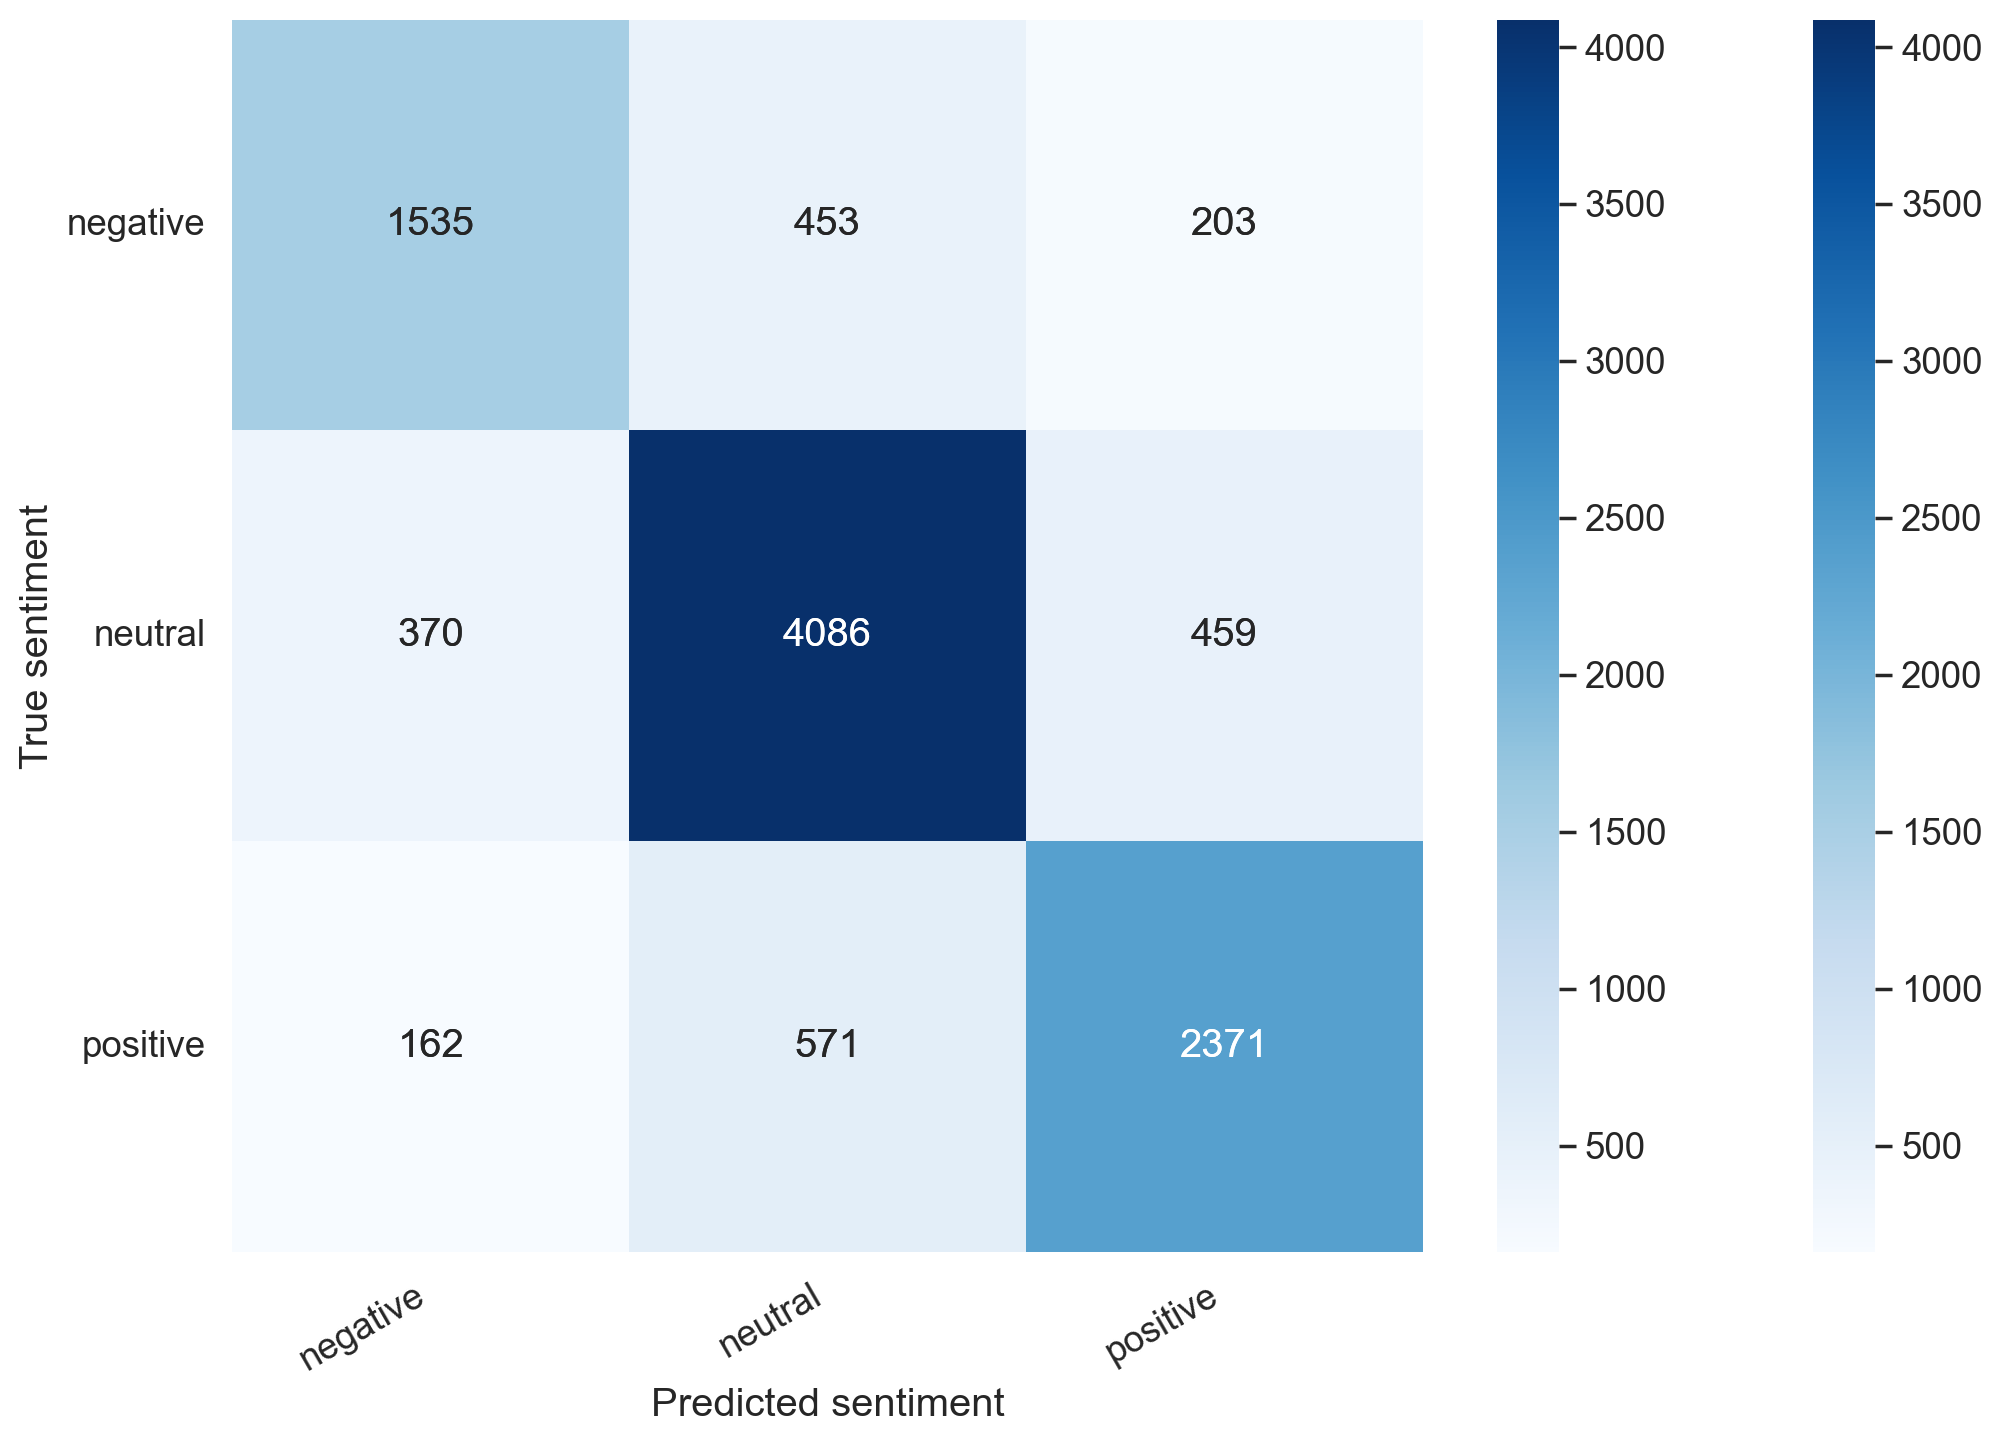

In [32]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')
  plt.show()

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Submission

In [34]:
from data_loader.data_loader import load_submission_data

submission_df = load_submission_data()

submission_data_loader = create_data_loader(submission_df, tokenizer, MAX_LEN, config.batch_size)

In [35]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  submission_data_loader
)

In [40]:
y_review_texts[489]

'Long Time Dead ?'

In [42]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
generate_submission(y_pred, label_map=label_map)

Submission file saved to submission.csv
